In [1]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import warnings
import numpy as np
warnings.filterwarnings("ignore")
os.environ['KMP_DUPLICATE_LIB_OK']='True' #esta linea salva vidas

In [ ]:
for dirpath, dirnames, filenames in os.walk("poner aqui ruta del dataset"):
  print(f"There are {len(filenames)} images in '{dirpath}'.")

In [ ]:
total_data= tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

In [2]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Caras',
    labels='inferred',
    label_mode="categorical",
    class_names=['disgust', 'fear','happy','neutral','sad','surprise'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(90,90), #Redimension de imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="training"
 
)

Found 24827 files belonging to 6 classes.
Using 21103 files for training.


In [3]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Caras',
    labels='inferred',
    label_mode="categorical",
    class_names=['disgust', 'fear','happy','neutral','sad','surprise'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(90,90), #Para redimensionar las imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="validation",
    

)

Found 24827 files belonging to 6 classes.
Using 3724 files for validation.


In [4]:
ds_train.class_names

['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
#IMAGENES Y LABELS TRAIN
X=[]
Y=[]
for i,(img,label) in enumerate(ds_train):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  X.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Y.append(label)

In [6]:
#IMAGENES Y LABELS TEST
Xtest=[]
Ytest=[]
for i,(img,label) in enumerate(ds_validation):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  Xtest.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Ytest.append(label)

In [7]:
from sklearn.model_selection import train_test_split
Xtest, Xval, Ytest, Yval = train_test_split(Xtest, Ytest, test_size=0.4, random_state=42)

In [8]:

X=np.array(X)
Xtest=np.array(Xtest)
Xval=np.array(Xval)
X[0]
Y=np.array(Y)
Ytest=np.array(Ytest)
Yval=np.array(Yval)

In [ ]:
#CHECKPOINT PARA ERRORES DE MEMORIA (soy pobre xd)
checkpoint_path="Expresion/checkpoint.ckpt"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=True,
                                                          save_freq="epoch",
                                                          verbose=1)

In [ ]:
#CREAMOS NUESTRO MODIFICADOR DE IMAGENES
#AL SUPONER QUE EL ANGULO DE LA CAMARA SERA IGUAL NO LO AÑADIREMOS AL MODELO
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.01, #ojito con el shear range
    zoom_range=[0.6,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]



)
data_gen_entrenamiento=datagen.flow(X,Y,batch_size=16)
data_gen_test=datagen.flow(Xtest,Ytest,batch_size=16)
#Le pasamos las imagenes y labels de entrenamiento
#Si algo falla aseurarse de tener las listas como np.array

In [9]:
#MIXED PRECISION PARA IR MAS RAPIDO Y GASTAR MENOS
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060, compute capability 8.9


# EFFICIENTNETB7 CON SUS PESOS

In [ ]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False,input_shape=(224,224,3),weights='imagenet')
base_model.summary()

In [ ]:
#PONEMOS PRIMERA CAPA PERSONALIZADA
model=tf.keras.Sequential()
#model.add(tf.keras.layers.Input(shape=(90,90,3), name='input_layer_perso'))
#CAMBIAMOS (90,90,1) A (90,90,3)
#model.add(tf.keras.layers.Conv2D(3, (1, 1), padding='same'))
#AÑADIMOS TODAS LAS CAPAS EXCEPTO LA PRIMERA
#for layer in base_model.layers[1:]:
 #   if isinstance(layer, (tf.keras.layers.Multiply, tf.keras.layers.Add)): # Verificar si la capa es de tipo Multiply
  #      model.add(tf.keras.layers.Lambda(lambda x: [x]))  # Envolver Multiply en una capa de lista
   # else:
    #    model.add(layer)
for layer in base_model.layers[0:]:
    model.add(layer)
    
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(6, activation="softmax",dtype='float32', name="output_layer"))
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])


In [ ]:
history = model.fit(X,Y,
                    #steps_per_epoch=len(X),
                    epochs=10,
                    batch_size=32,
                    validation_data=(Xval,Yval),
                    #validation_steps=len(Xtest),
                    callbacks=[checkpoint_callback] #out of memory page error happening after 4 to 5 epoch
                                       )

In [ ]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# MODELO 2 CNN MANUAL

In [ ]:
###### from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, AveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

## Extracción de Características
model.add(Conv2D(32,(3,3),padding = 'same',input_shape = (120,120,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

## Clasificación
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

# Revisamos el modelo CNN
model.summary()

# Compilamos y estamos listos para el entrenamiento
opt = Adam(learning_rate=1e-4, decay=1e-4 / 32)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
history=model.fit(  
    X,Y,
    epochs=32,
    validation_data=(Xtest,Ytest),
    steps_per_epoch=int(np.ceil(len(X)/float(32))),
    validation_steps=int(np.ceil(len(Xtest)/float(32)))
)

In [ ]:
# Extraer la información de la pérdida y la precisión de los historiales
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Graficar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Graficar la precisión durante el entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Ajustar el diseño de los gráficos y mostrarlos
plt.tight_layout()
plt.show()

# MODELO 3 VGG16 AJUSTADO A ESCALA DE GRISES

In [19]:
# Cargar el modelo preentrenado en imágenes a color
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(90, 90, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 90, 90, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 90, 90, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 45, 45, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 45, 45, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 45, 45, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 22, 22, 128)       0     

In [20]:
# Modificar la capa de entrada para aceptar imágenes en escala de grises
new_model=tf.keras.Sequential()
#new_model.add(tf.keras.layers.Input(shape=(90, 90, 1)))
#Simular el rgb
#Esta capa juto a la input (120,120,1) -> (120,120,3)
#new_model.add(tf.keras.layers.Conv2D(3, (1, 1), padding='same'))


# Añadir todas las capaas excepto la primera
contador=0
for layer in base_model.layers[0:]:
    if contador<5:
        layer.trainable=False
    new_model.add(layer)
    contador+=1
#Añadimos las capas finales
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(tf.keras.layers.Dense(128,activation='relu'))
new_model.add(tf.keras.layers.Dense(6, activation="softmax",dtype='float32', name="output_layer"))
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 90, 90, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 90, 90, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 45, 45, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 45, 45, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 45, 45, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 22, 22, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 22, 22, 256)      

In [21]:
# Compilamos y estamos listos para el entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6 / 32)
#AL DISMINUIR EL DECAY HACEMOS QUE EL LEARNING RATE TARDE MAS EN CAMBIAR
new_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 678105372427965783
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5728370688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11484846646842422746
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [23]:
history=new_model.fit(  
    X,Y,
    epochs=4,
    validation_data=(Xval,Yval),
    steps_per_epoch=int(np.ceil(len(X)/float(16))),
    validation_steps=int(np.ceil(len(Xval)/float(16)))
)

Epoch 1/4
1319/1319 [==============================] - 25s 18ms/step - loss: 1.1552 - accuracy: 0.5385 - val_loss: 1.0659 - val_accuracy: 0.5812
Epoch 2/4
1319/1319 [==============================] - 23s 18ms/step - loss: 0.9070 - accuracy: 0.6432 - val_loss: 0.8947 - val_accuracy: 0.6577
Epoch 3/4
1319/1319 [==============================] - 23s 18ms/step - loss: 0.7796 - accuracy: 0.6941 - val_loss: 0.8282 - val_accuracy: 0.6772
Epoch 4/4
1319/1319 [==============================] - 23s 18ms/step - loss: 0.6614 - accuracy: 0.7461 - val_loss: 0.8760 - val_accuracy: 0.6792


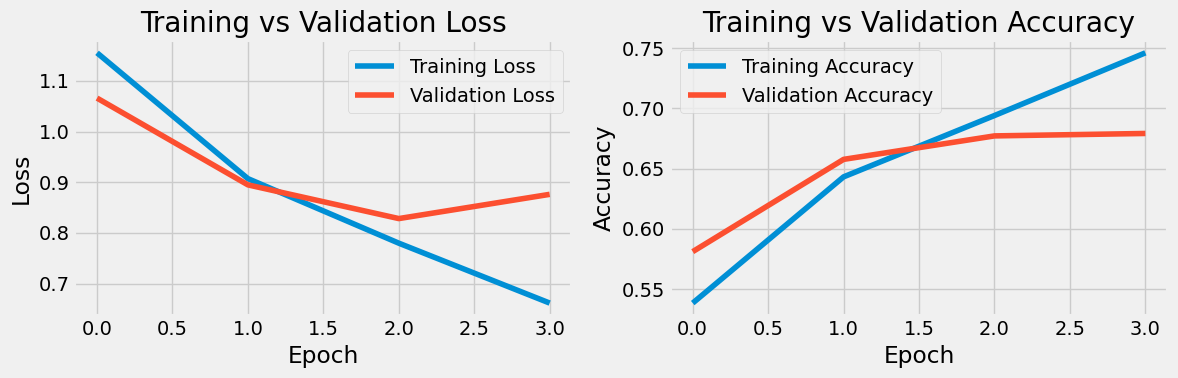

In [24]:
# Extraer la información de la pérdida y la precisión de los historiales
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Graficar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Graficar la precisión durante el entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Ajustar el diseño de los gráficos y mostrarlos
plt.tight_layout()
plt.show()

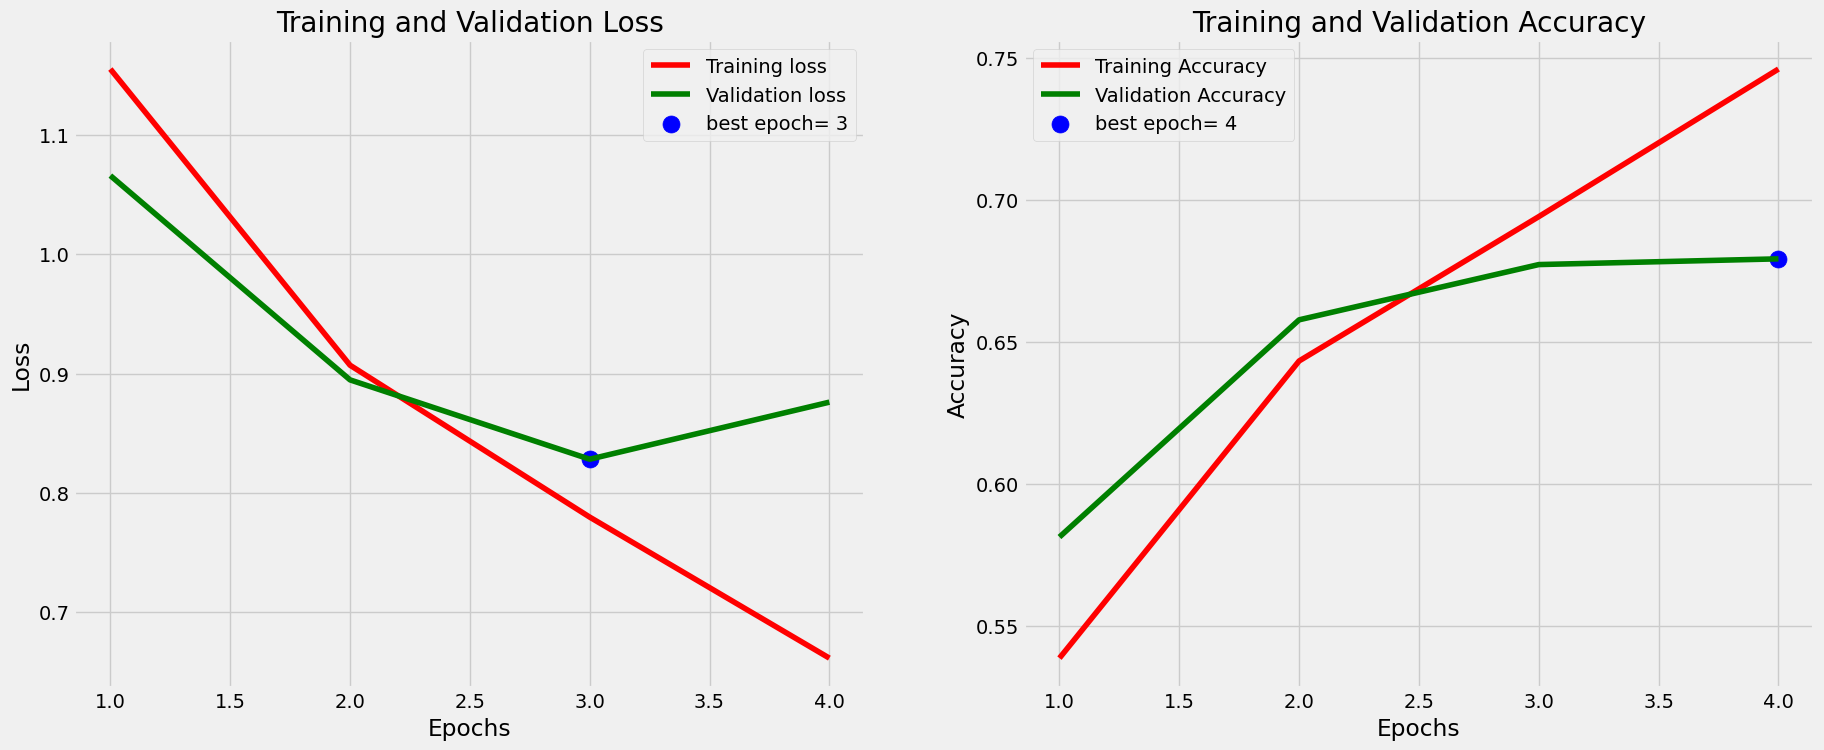

In [25]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}' 

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [29]:
#HACEMOS UN TEST
test_loss = new_model.evaluate(Xtest,Ytest)
print(f"Test loss is: {test_loss}")

70/70 [==============================] - 1s 19ms/step - loss: 0.8926 - accuracy: 0.6750
Test loss is: [0.8925551772117615, 0.6750223636627197]


In [27]:
#Predicciones
prediccion= new_model.predict(Xtest)
print(f"{prediccion}\n")

70/70 [==============================] - 1s 15ms/step
[[5.3742287e-08 2.6022694e-06 9.9739361e-01 2.5798969e-03 3.4083980e-06
  2.0530350e-05]
 [4.6436991e-05 1.7672624e-03 1.1093984e-02 9.7543585e-01 1.1272086e-02
  3.8425051e-04]
 [4.1883914e-03 4.4830739e-02 7.6102370e-01 5.1703183e-03 7.2667161e-03
  1.7752017e-01]
 ...
 [4.9160130e-02 1.1780183e-01 1.9540986e-02 4.7372974e-02 7.6467454e-01
  1.4495971e-03]
 [3.4412056e-01 2.8446418e-01 6.4865774e-03 8.4937274e-02 2.7503496e-01
  4.9564838e-03]
 [5.8550695e-03 2.1444511e-01 1.1105592e-02 4.2753997e-01 3.1579414e-01
  2.5260121e-02]]



In [ ]:
print(tf.__version__)

In [30]:
new_model.save('Prueba_67.h5')
from IPython import display
from ipywidgets import FileUpload

display.FileLink('Prueba_67.h5')
display.display(display.FileLink('Prueba_67.h5', result_html_prefix="Haz clic aquí para descargar: "))

C:\Users\Miguel\Prueba_67.h5

# MODELO 4 RESNET50

In [ ]:
base_model=tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(90, 90, 3))
base_model.summary()

In [ ]:
#conexion para transfer learning
#nos enganchamos a la ultima capa
x = base_model.layers[-2].output
#añadimos capas para fine tuning
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten(name='cflatten')(x)

#x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.3)(x)

output= tf.keras.layers.Dense(6,activation='softmax',name='output',dtype='float32')(x)
#ponemos la input layer del modelo y el resto con el fine tunning
new_model = tf.keras.models.Model(base_model.inputs, output)
new_model.summary()

In [ ]:
# Compilamos y estamos listos para el entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6 / 32)
#AL DISMINUIR EL DECAY HACEMOS QUE EL LEARNING RATE TARDE MAS EN CAMBIAR
new_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
history=new_model.fit(  
    X,Y,
    epochs=4,
    validation_data=(Xval,Yval),
    steps_per_epoch=int(np.ceil(len(X)/float(16))),
    validation_steps=int(np.ceil(len(Xval)/float(16)))
)

In [ ]:
# Extraer la información de la pérdida y la precisión de los historiales
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Graficar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Graficar la precisión durante el entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Ajustar el diseño de los gráficos y mostrarlos
plt.tight_layout()
plt.show()

In [ ]:
#HACEMOS UN TEST
test_loss = new_model.evaluate(Xtest,Ytest)
print(f"Test loss is: {test_loss}")